# Andamento della temperatura mensile italiana

## Analisi della serie storica

Vogliamo determinare un modello dell'andamento della temperatura mensile italiana media. I dati riportano la temperatura media mensile dal 1901 al 2020, tratti da https://climateknowledgeportal.worldbank.org/download-data.

Dati tratti dalla sezione "Timeseries > CRU (Observed)" (CRU = Climatic Research Unit).

Si tratta delle temperature medie nell'arco di un mese.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
import math
import matplotlib.gridspec as gridspec
from scipy.fft import fft, ifft
from scipy.stats import chi2
from scipy.stats import norm

In [2]:
df_tab=pd.read_csv('tas_timeseries_monthly_cru_1901-2021_ITA.csv', skiprows=[0,1])
df_tab.rename(columns={'Unnamed: 0' :'year'}, inplace=True)
df_tab

,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1901,1.90,0.75,6.50,10.67,13.91,19.03,21.11,20.58,17.89,13.16,6.94,5.51
1,1902,4.51,5.55,7.07,11.78,11.34,17.04,21.36,20.83,17.96,12.78,7.07,3.93
2,1903,3.33,5.35,7.90,7.89,14.32,16.88,20.17,20.87,17.90,13.64,8.23,5.28
3,1904,3.72,5.73,7.35,11.37,15.39,19.39,22.67,21.31,16.16,12.80,6.71,4.79
4,1905,0.95,3.05,7.43,10.17,13.57,18.25,22.61,21.23,18.74,10.04,8.74,5.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2017,2.52,7.20,9.99,11.48,16.38,21.65,23.17,23.86,17.41,14.24,8.66,4.78
117,2018,6.91,4.27,7.60,13.67,16.91,20.34,23.31,23.56,20.07,15.46,10.57,6.19
118,2019,3.93,6.66,9.21,11.51,13.24,21.50,23.60,23.52,19.55,15.68,10.33,7.65
119,2020,6.04,7.89,8.32,12.45,16.26,19.05,22.57,23.42,19.68,13.40,10.55,6.41


In [3]:
df = pd.melt(df_tab, id_vars=["year"], var_name="month", value_name = "temp")
df['temp_err'] = 1.267
df['m'] = pd.to_datetime(df.month, format='%b').dt.month
df['date'] = df['year']+(df['m']-1)/12
df = df.sort_values(by=['date'])

In [4]:
df

,year,month,temp,temp_err,m,date
0,1901,Jan,1.90,1.267,1,1901.000000
121,1901,Feb,0.75,1.267,2,1901.083333
242,1901,Mar,6.50,1.267,3,1901.166667
363,1901,Apr,10.67,1.267,4,1901.250000
484,1901,May,13.91,1.267,5,1901.333333
...,...,...,...,...,...,...
967,2021,Aug,22.69,1.267,8,2021.583333
1088,2021,Sep,20.09,1.267,9,2021.666667
1209,2021,Oct,13.76,1.267,10,2021.750000
1330,2021,Nov,9.81,1.267,11,2021.833333


In [5]:
y_min, y_max = df['date'].min(), df['date'].max()
y_delta = y_max - y_min

Grafico dell'andamento temporale.

È evidente la struttura periodica.

Negli ultimi anni va cercato un accenno all'aumento della temperatura.

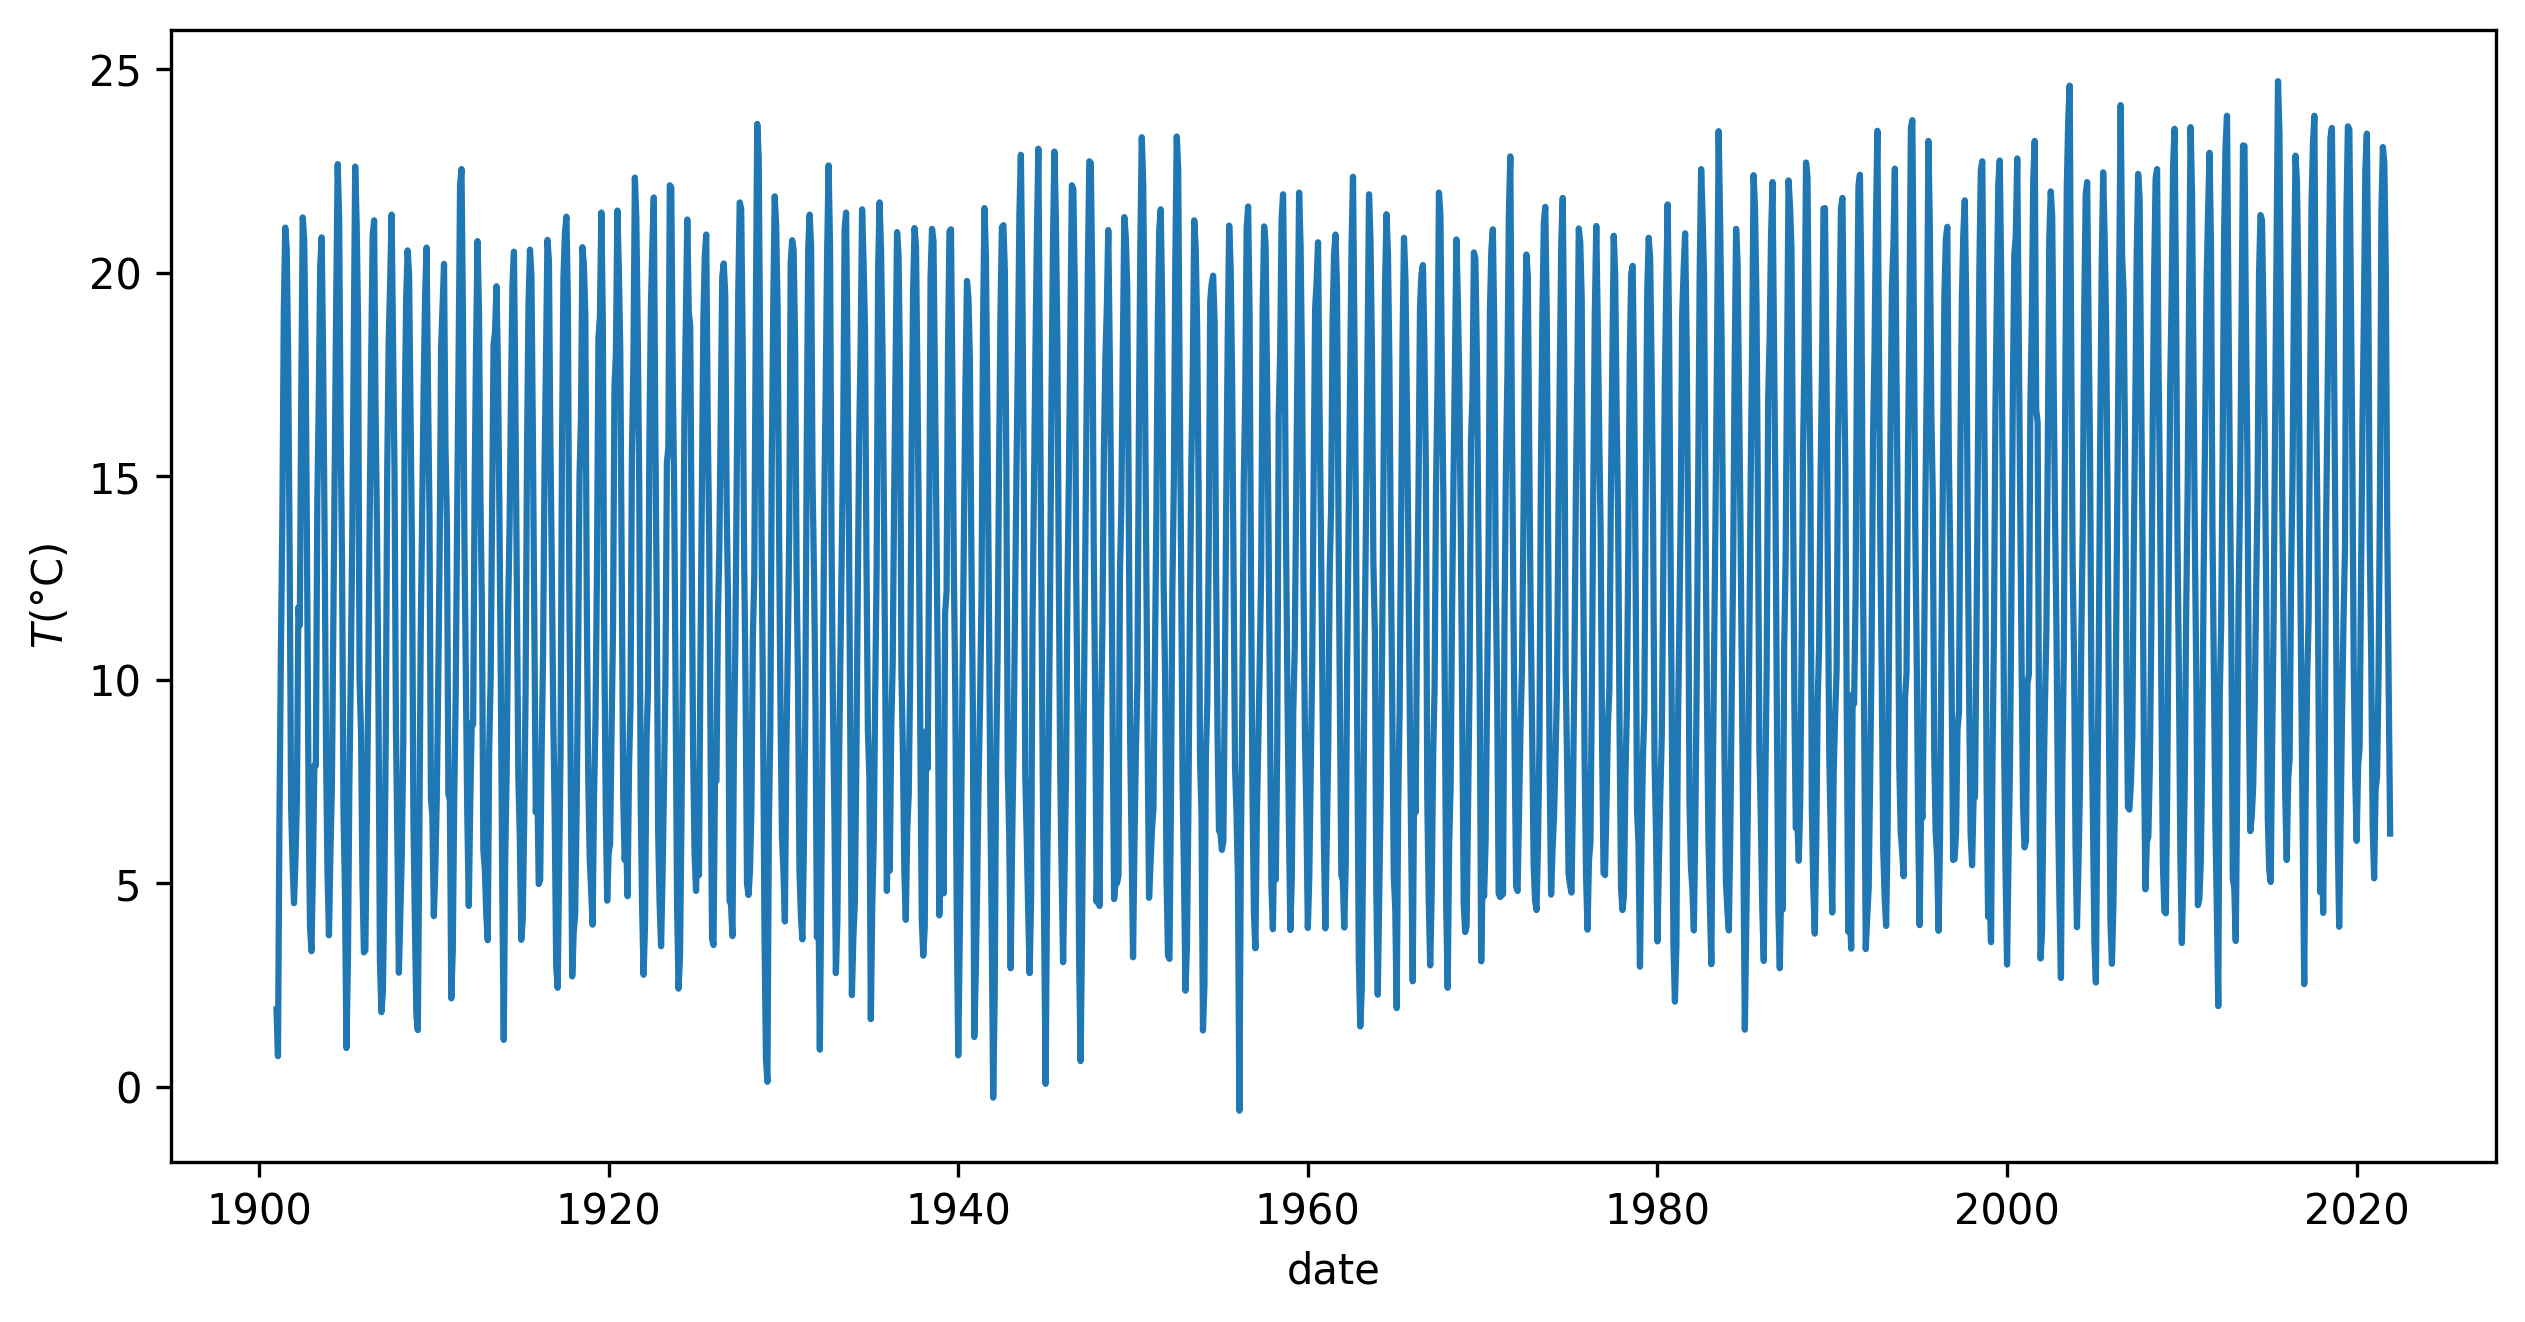

In [6]:
plt.figure(figsize=(10,5),dpi=300)
plt.plot(df['date'],df['temp'])
plt.ylabel('$T$(°C)' )
plt.xlabel('date')
plt.show()

Definiamo una funzione per il calcolo del $\chi^2$ del fit e del corrispondente $p$-value.

In [7]:
def chi2_p(df, m):
    c2, ndof = m.fval, len(df['date']) - m.nfit
    c2n = c2/ndof
    print("chi^2={:.2f}/{:d}={:.2f}".format(c2, ndof, c2n))
    p_val=chi2.sf(c2, ndof)
    print("p-value = {:.5e}".format(p_val))

Definiamo una funzione per fraficare il fit in maniera generica, che servirà anche per i modelli di fit successivi.

In [8]:
def plot(m, fit, y1=y_min, y2=y_max):
    y_fit = fit.fun(df['date'], m.values)
    npt_curve = 3000
    x_curve = np.linspace(y1, y2, npt_curve)
    y_fit_curve = fit.fun(x_curve, m.values)
    y_base = fit.baseline.fun(x_curve, m.values)
    y_t0 = np.full_like(x_curve, m.values[0])
    y_amp = fit.amplitude.fun(x_curve, m.values)
    y_up, y_lo = y_base + y_amp, y_base - y_amp
    plt.figure(figsize=(12,8), dpi=100)
    gs = gridspec.GridSpec(8, 1)
    ax0 = plt.subplot(gs[:5, :])
    ax1 = plt.subplot(gs[6:, :])
    ax0.errorbar(df['date'], df['temp'], df['temp_err'], fmt="o", markersize=2, color='blue')
    ax0.plot(x_curve, y_fit_curve, label="modello", color='orange')
    ax0.plot(x_curve, y_base, label="media", color='red')
    ax0.plot(x_curve, y_up, label="massima", color='goldenrod')
    ax0.plot(x_curve, y_lo, label="minima", color='goldenrod')
    ax0.plot(x_curve, y_t0, label=r"$T_0$", color='green')
    ax0.set_ylabel('$T_{month}$')
    ax1.plot([y1, y2], [0, 0], color='red', zorder=10)
    ax1.errorbar(df['date'], df['temp']-y_fit, df['temp_err'], fmt="o", markersize=2, color='blue')
    ax0.set_xlabel('time')
    ax1.set_xlabel('time')
    ax1.set_ylabel('res.')    
    ax0.set_xlim([y1, y2])
    ax1.set_xlim([y1, y2])
    fit_info = [ r"$\chi^2$ / $n_\mathrm{{dof}}$ = {:.1f} / {:d}".format(m.fval,len(df['date']) - m.nfit) ]
    for i in range(m.npar):
        p=m.parameters[i]
        v=m.values[i]
        e=m.errors[i]
        fit_info.append(f"{p} = ${v:.2f} \\pm {e:.2f}$")
    title = "{:.0f}-{:.0f}".format(y1, y2)
    ax0.set_title(title)
    ax0.legend(title="\n".join(fit_info), loc='lower left', ncol=2)
    plt.show()

Definiamo un modello di fit. L'uso di classi semplifica un po' la flessibilità del modello per le modifiche successive che saranno presentate. 

In [9]:
class const_baseline_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 1
    def fun(self, x, par):
        return np.full_like(x, par[self.idx])

In [10]:
class const_amplitude_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 1        
    def fun(self, x, par):
        return np.full_like(x, par[self.idx])

In [11]:
class fit_fun:
    def __init__(self, baseline, amplitude):
        self.baseline = baseline
        self.amplitude = amplitude
        amplitude.idx = baseline.idx + baseline.pars
        self.idx = amplitude.idx + amplitude.pars
        self.pars = self.baseline.pars + self.amplitude.pars + 2
    def fun(self, x, par):
        return self.baseline.fun(x,par)+self.amplitude.fun(x,par)*np.cos((2*np.pi/par[self.idx])*(x+par[self.idx+1]))
        

Funzione di fit di base: andamento sinusoidale senza variazione nel tempo della *baseline*:
    
$\displaystyle T(t) = T_0 + A_0 \cos\left(\frac{2\pi}{T}(t-t_0)\right)$

In [12]:
fit = fit_fun(const_baseline_fun(), const_amplitude_fun())
least_squares_mode = LeastSquares(df['date'], df['temp'] , df['temp_err'], fit.fun)
m = Minuit(least_squares_mode, (12, 9, 1, 0.249), name=("$T_0$", "$A_0$", "$T$", "$t_0$"))
m.limits = [(None, None), (0, None), (0.9, 1.1), (0, 1)]
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1681                       │              Nfcn = 102              │
│ EDM = 4.84e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $T_0$ │  12.399   │   0.033   │            │            │         │         │       │
│ 1 │ $A_0$ │   8.80    │   0.05    │            │            │    0    │         │       │
│ 2 │ $T$   │ 1.000005  │ 0.000024  │            │            │   0.9   │   1.1   │       │
│ 3 │ $t_0$ │   0.48    │   0.05    │            │            │    0    │    1    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────┐
│       │     $T_0$     $A_0$       $T$     $t_0$ │
├───────┼─────────────────────────────────────────┤
│ $T_0$ │   0.00111 -2.03e-08 -4.78e-09 -9.38e-06 │
│ $A_0$ │ -2.03e-08   0.00221  2.43e-09  4.79e-06 │
│   $T$ │ -4.78e-09  2.43e-09  5.89e-10  1.16e-06 │
│ $t_0$ │ -9.38e-06  4.79e-06  1.16e-06   0.00227 │
└───────┴─────────────────────────────────────────┘

Da notare che il periodo $T$ è compatibile con grade precisione con un anno.

In [13]:
print('hottest date, in months: {:.2f}'.format(13-m.values[-1]*12))
chi2_p(df, m)

hottest date, in months: 7.20
chi^2=1680.77/1448=1.16
p-value = 1.84948e-05


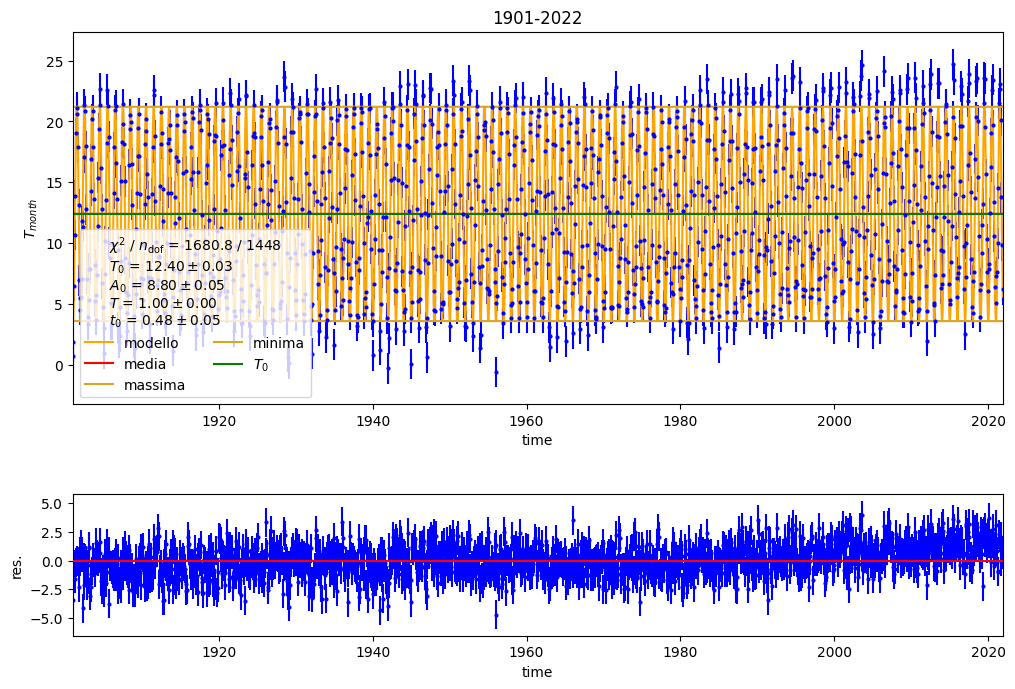

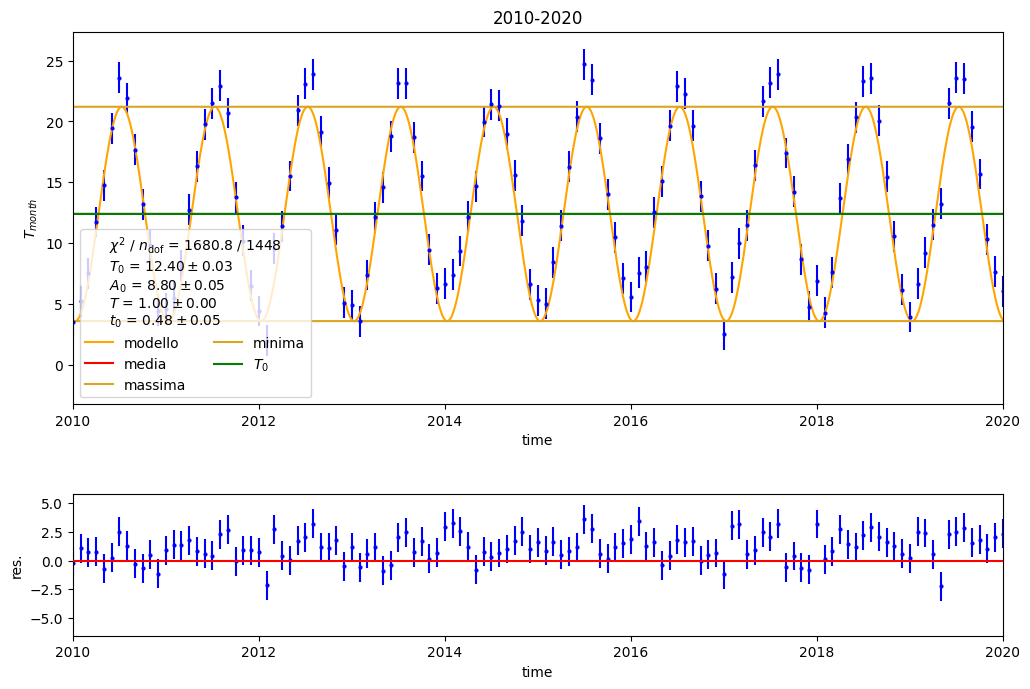

In [14]:
plot(m, fit)
plot(m, fit, 2010, 2020)

I residui mostrano molto chiaramente una discrepanza negli ultimi trent'anni circa.

In [15]:
class pow_baseline_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 3
    def fun(self, x, par):
        return par[self.idx]+par[self.idx+1]*np.power((x-y_min)/y_delta,par[self.idx+2])
fit_1 = fit_fun(pow_baseline_fun(), const_amplitude_fun())

Prima variazione: modulazione della *baseline* come legge di potenza:
    
$\displaystyle T(t) = T_0 + T_1 \left(\frac{t-t_{\mathrm{min}}}{t_{\mathrm{max}}-t_{\mathrm{min}}}\right)^\alpha+A_0 \cos\left(\frac{2\pi}{T}(t-t_0)\right)$

In [16]:
least_squares_mode = LeastSquares(df['date'], df['temp'] , df['temp_err'], fit_1.fun)
m_1 = Minuit(least_squares_mode, (m.values[0],0.0001,1.0001,m.values[1],m.values[2],m.values[3]), name=("$T_0$", "$T_1$", r"$\alpha$", "$A_0$", "$T$", "$t_0$"))
m_1.limits = [(None, None), (0, None), (1, None), (0, None), (0.9, 1.1), (0.3, 0.6)]
m_1.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1444                       │              Nfcn = 270              │
│ EDM = 1.24e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $T_0$    │   12.02   │   0.05    │            │            │         │         │       │
│ 1 │ $T_1$    │   1.92    │   0.14    │            │            │    0    │         │       │
│ 2 │ $\alpha$ │    4.1    │    0.6    │            │            │    1    │         │       │
│ 3 │ $A_0$    │   8.80    │   0.05    │            │            │    0    │         │       │
│ 4 │ $T$      │ 1.000002  │ 0.000025  │            │            │   0.9   │   1.1   │       │
│ 5 │ $t_0$    │   0.48    │   0.05    │            │            │   0.3   │   0.6   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────┐
│          │     $T_0$     $T_1$  $\alpha$     $A_0$       $T$     $t_0$ │
├──────────┼─────────────────────────────────────────────────────────────┤
│    $T_0$ │   0.00275 -0.000778    0.0198  7.95e-07 -1.06e-08 -2.08e-05 │
│    $T_1$ │ -0.000778    0.0208    0.0445  -2.3e-05 -4.33e-08 -8.41e-05 │
│ $\alpha$ │    0.0198    0.0445     0.382 -4.91e-05 -1.88e-07 -0.000367 │
│    $A_0$ │  7.95e-07  -2.3e-05 -4.91e-05   0.00221  7.61e-09   1.5e-05 │
│      $T$ │ -1.06e-08 -4.33e-08 -1.88e-07  7.61e-09  6.11e-10   1.2e-06 │
│    $t_0$ │ -2.08e-05 -8.41e-05 -0.000367   1.5e-05   1.2e-06   0.00236 │
└──────────┴─────────────────────────────────────────────────────────────┘

In [17]:
chi2_p(df, m_1)

chi^2=1443.96/1446=1.00
p-value = 5.10199e-01


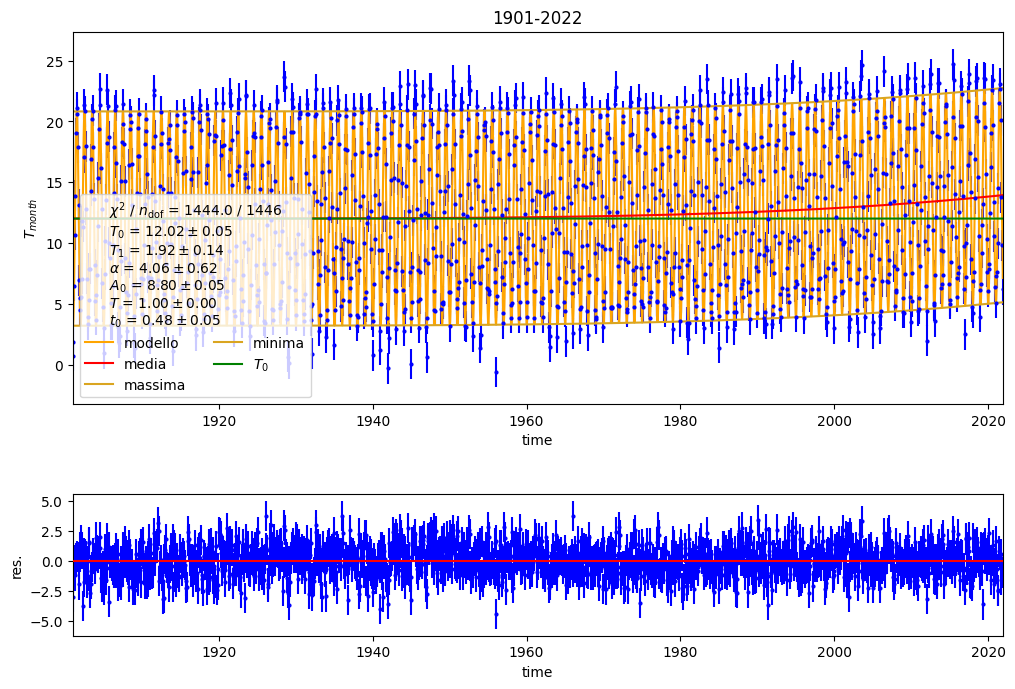

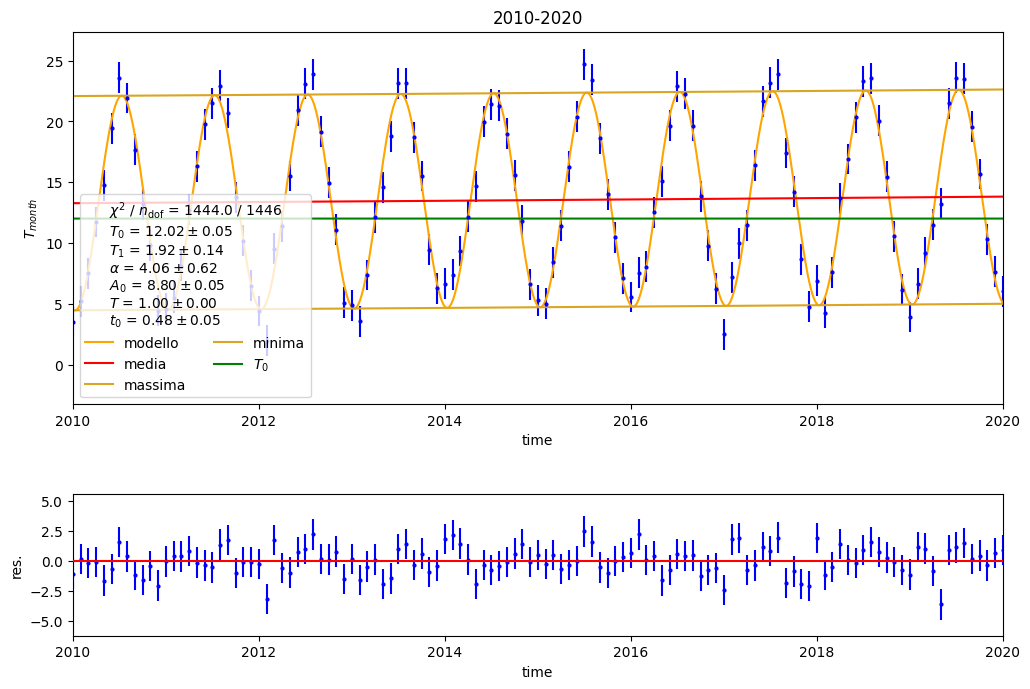

In [18]:
plot(m_1, fit_1)
plot(m_1, fit_1, 2010, 2020)

In [19]:
class pow_amplitude_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 3
    def fun(self, x, par):
        return par[self.idx]+par[self.idx+1]*np.power((x-y_min)/y_delta,par[self.idx+2])
fit_2 = fit_fun(pow_baseline_fun(), pow_amplitude_fun())

Seconda variazione: modulazione dell'ampiezza come legge di potenza:
    
$\displaystyle T(t) = \left[T_0 + T_1 \left(\frac{t-t_{\mathrm{min}}}{t_{\mathrm{max}}-t_{\mathrm{min}}}\right)^\alpha\right]+\left[A_0+A_1 \left(\frac{t-t_{\mathrm{min}}}{t_{\mathrm{max}}-t_{\mathrm{min}}}\right)^\beta \right]\cos\left(\frac{2\pi}{T}(t-t_0)\right)$

In [20]:
least_squares_mode = LeastSquares(df['date'], df['temp'] , df['temp_err'], fit_2.fun)
m_2 = Minuit(least_squares_mode, (m_1.values[0],m_1.values[2],m_1.values[3],m_1.values[4],0.0001,1.0001,m_1.values[4],m_1.values[5]), name=("$T_0$", "$T_1$", r"$\alpha$", "$A_0$", "$A_1$", r"$\beta$", "$T$", "$t_0$"))
m_2.limits = [(None, None), (0, None), (1, None), (0, None), (0, None), (1, None), (0.9, 1.1), (0.3, 0.6)]
m_2.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1441                       │              Nfcn = 531              │
│ EDM = 9.31e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $T_0$    │   12.02   │   0.05    │            │            │         │         │       │
│ 1 │ $T_1$    │   1.92    │   0.14    │            │            │    0    │         │       │
│ 2 │ $\alpha$ │    4.0    │    0.6    │            │            │    1    │         │       │
│ 3 │ $A_0$    │   8.75    │   0.06    │            │            │    0    │         │       │
│ 4 │ $A_1$    │   0.35    │   0.21    │            │            │    0    │         │       │
│ 5 │ $\beta$  │     6     │     4     │            │            │    1    │         │       │
│ 6 │ $T$      │ 1.000002  │ 0.000023  │            │            │   0.9   │   1.1   │       │
│ 7 │ $t_0$    │   0.48    │   0.05    │            │            │   0.3   │   0.6   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────────────────────────────────────────────┐
│          │     $T_0$     $T_1$  $\alpha$     $A_0$     $A_1$   $\beta$       $T$     $t_0$ │
├──────────┼─────────────────────────────────────────────────────────────────────────────────┤
│    $T_0$ │   0.00275 -0.000782    0.0198  5.47e-06 -4.26e-05 -0.000235 -9.57e-09 -1.88e-05 │
│    $T_1$ │ -0.000782    0.0208    0.0443  8.13e-06  -0.00038  -0.00345 -3.94e-08 -7.64e-05 │
│ $\alpha$ │    0.0198    0.0443      0.38  6.27e-05  -0.00125   -0.0101 -1.72e-07 -0.000335 │
│    $A_0$ │  5.47e-06  8.13e-06  6.27e-05   0.00334   -0.0043    0.0713  -1.3e-09 -2.59e-06 │
│    $A_1$ │ -4.26e-05  -0.00038  -0.00125   -0.0043    0.0446     0.297 -3.35e-09 -6.46e-06 │
│  $\beta$ │ -0.000235  -0.00345   -0.0101    0.0713     0.297        16  3.27e-07  0.000639 │
│      $T$ │ -9.57e-09 -3.94e-08 -1.72e-07  -1.3e-09 -3.35e-09  3.27e-07  5.42e-10  1.06e-06 │
│    $t_0$ │ -1.88e-05 -7.64e-05 -0.000335 -2.59e-06 -6.46e-06  0.000639  1.06e-06   0.00209 │
└──────────┴─────────────────────────────────────────────────────────────────────────────────┘

In [21]:
chi2_p(df, m_2)

chi^2=1440.88/1444=1.00
p-value = 5.18227e-01


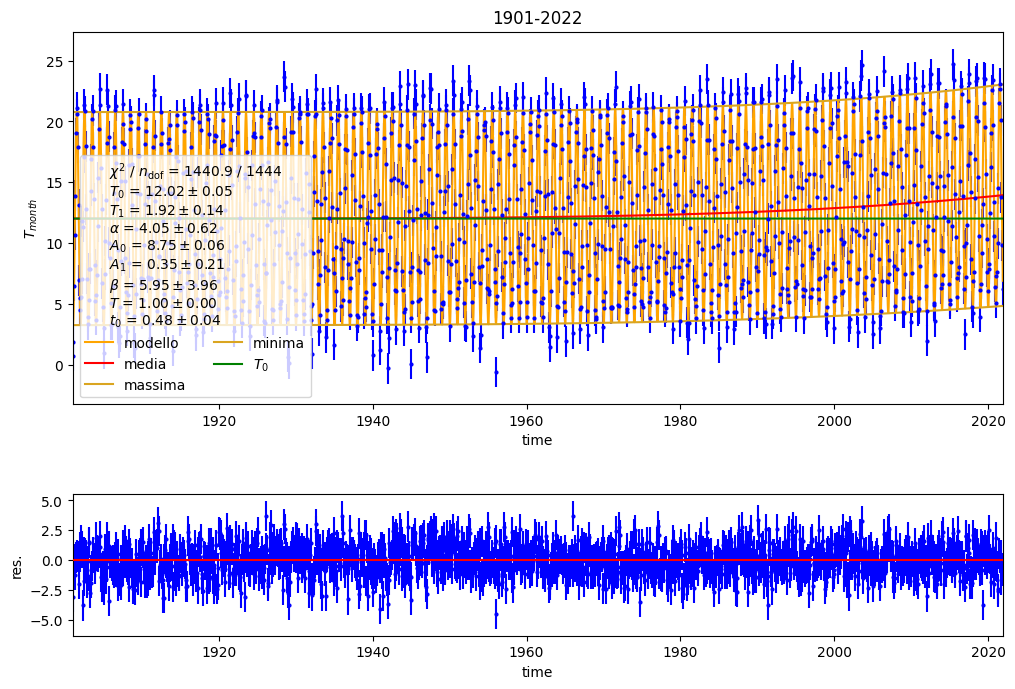

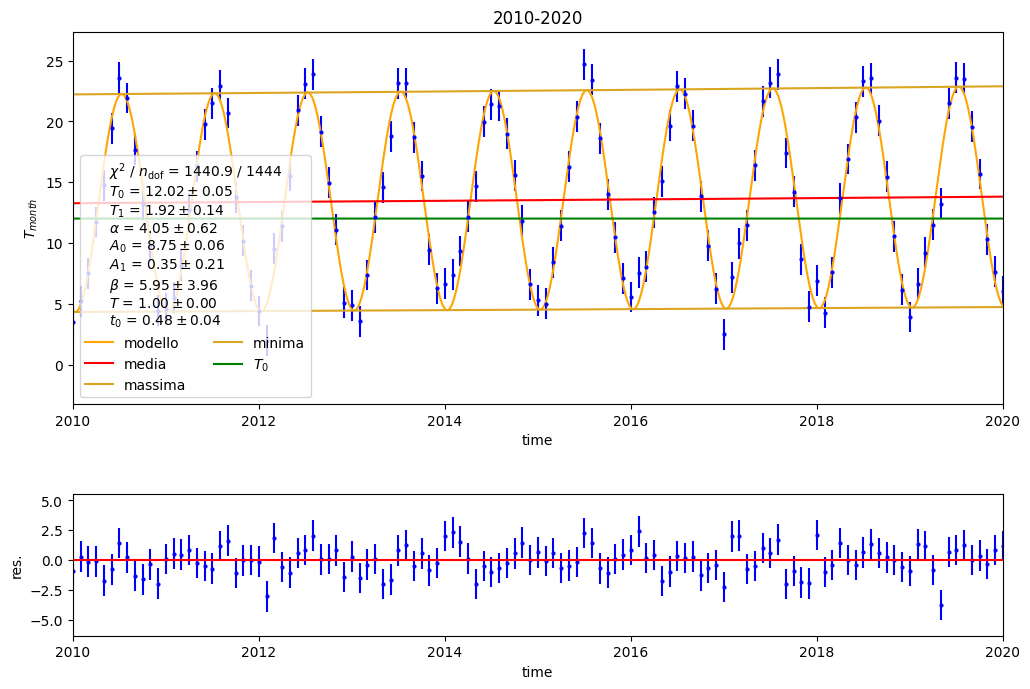

In [22]:
plot(m_2, fit_2)
plot(m_2, fit_2, 2010, 2020)

In [23]:
z = m_2.values[4]/m_2.errors[4]
print('Significance A1>0: {:.3f}'.format(z))
print('p-value A1>0: {:.3f}'.format(norm.sf(abs(z))))

Significance A1>0: 1.668
p-value A1>0: 0.048


In [24]:
class powx_amplitude_fun:
    def __init__(self):
        self.idx = 0
        self.pars = 2
    def fun(self, x, par):
        return par[self.idx]+par[self.idx+1]*np.power((x-y_min)/y_delta,par[self.idx-2])
fit_3 = fit_fun(pow_baseline_fun(), powx_amplitude_fun())

Terza variazione: modulazione assumiamo come ipotesi $\alpha=\beta$:
    
$\displaystyle T(t) = \left[T_0 + T_1 \left(\frac{t-t_{\mathrm{min}}}{t_{\mathrm{max}}-t_{\mathrm{min}}}\right)^\alpha\right]+\left[A_0+A_1 \left(\frac{t-t_{\mathrm{min}}}{t_{\mathrm{max}}-t_{\mathrm{min}}}\right)^\alpha \right]\cos\left(\frac{2\pi}{T}(t-t_0)\right)$

In [25]:
least_squares_mode = LeastSquares(df['date'], df['temp'] , df['temp_err'], fit_3.fun)
m_3 = Minuit(least_squares_mode, (m_1.values[0],m_1.values[2],m_1.values[3],m_1.values[4],0.0001,m_1.values[4],m_1.values[5]), name=("$T_0$", "$T_1$", r"$\alpha$", "$A_0$", "$A_1$", "$T$", "$t_0$"))
m_3.limits = [(None, None), (0, None), (1, None), (0, None), (0, None), (0.9, 1.1), (0.3, 0.6)]
m_3.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1442                       │              Nfcn = 422              │
│ EDM = 9.84e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $T_0$    │   12.02   │   0.05    │            │            │         │         │       │
│ 1 │ $T_1$    │   1.93    │   0.14    │            │            │    0    │         │       │
│ 2 │ $\alpha$ │    4.1    │    0.6    │            │            │    1    │         │       │
│ 3 │ $A_0$    │   8.73    │   0.07    │            │            │    0    │         │       │
│ 4 │ $A_1$    │   0.21    │   0.15    │            │            │    0    │         │       │
│ 5 │ $T$      │ 1.000002  │ 0.000024  │            │            │   0.9   │   1.1   │       │
│ 6 │ $t_0$    │   0.48    │   0.05    │            │            │   0.3   │   0.6   │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────────────────────────────────────────────────────┐
│          │     $T_0$     $T_1$  $\alpha$     $A_0$     $A_1$       $T$     $t_0$ │
├──────────┼───────────────────────────────────────────────────────────────────────┤
│    $T_0$ │   0.00275 -0.000769    0.0199   2.8e-07 -5.39e-05  -9.7e-09 -1.91e-05 │
│    $T_1$ │ -0.000769    0.0208    0.0447  0.000292  0.000596 -3.99e-08 -7.73e-05 │
│ $\alpha$ │    0.0199    0.0447     0.382  0.000713   0.00103 -1.74e-07  -0.00034 │
│    $A_0$ │   2.8e-07  0.000292  0.000713   0.00508   -0.0084  1.26e-10  2.74e-07 │
│    $A_1$ │ -5.39e-05  0.000596   0.00103   -0.0084    0.0247 -1.58e-08 -3.09e-05 │
│      $T$ │  -9.7e-09 -3.99e-08 -1.74e-07  1.26e-10 -1.58e-08  5.55e-10  1.09e-06 │
│    $t_0$ │ -1.91e-05 -7.73e-05  -0.00034  2.74e-07 -3.09e-05  1.09e-06   0.00214 │
└──────────┴───────────────────────────────────────────────────────────────────────┘

In [26]:
chi2_p(df, m_3)

chi^2=1442.12/1445=1.00
p-value = 5.16423e-01


Le correlazioni sono per fortuna piccole. Questo potrebbe semplificarci la vita nella propagazione degli errori.

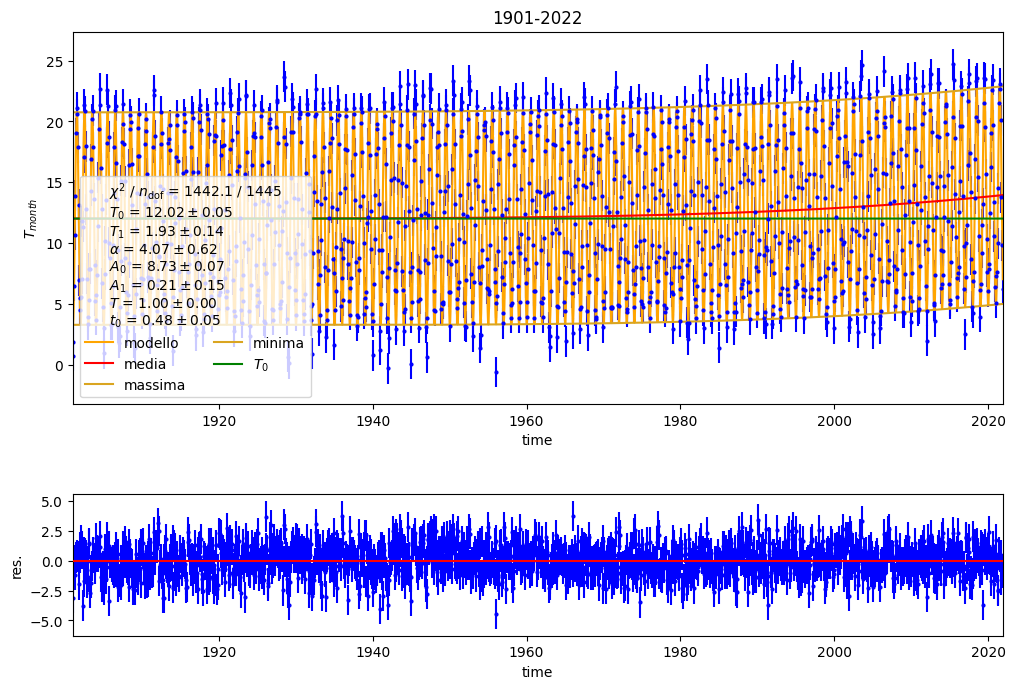

In [27]:
plot(m_3, fit_3)

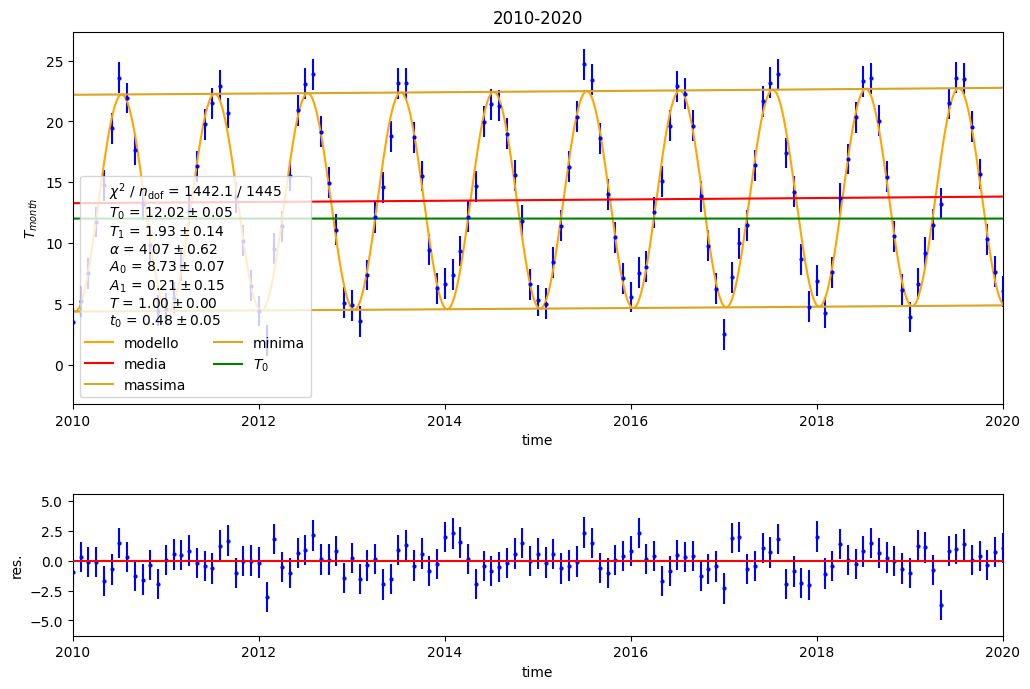

In [28]:
plot(m_3, fit_3, 2010, 2020)

In [29]:
z = m_3.values[4]/m_3.errors[4]
print('Significance A1>0: {:.3f}'.format(z))
print('p-value A1>0: {:.3f}'.format(norm.sf(abs(z))))

Significance A1>0: 1.381
p-value A1>0: 0.084


Estrapoliamo al 2080.

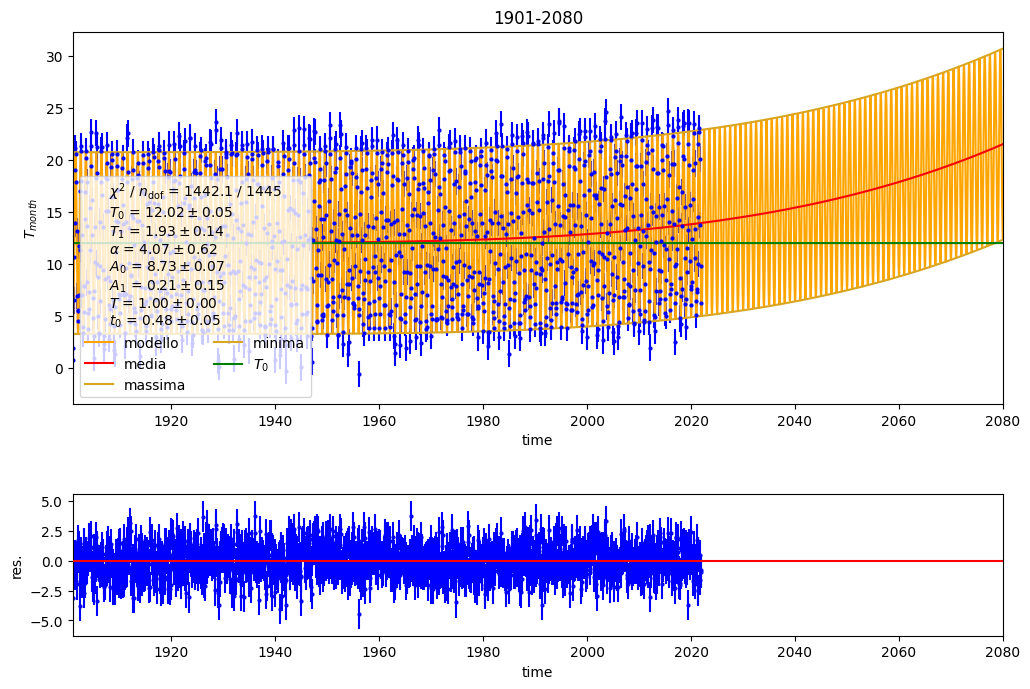

In [30]:
plot(m_3, fit_3, 1901, 2080)